# Bike Helmet Detection - Testing Notebook
_This Notebook contains all my dev tests and the methods I implemented and used in my project_demo.py_

<img src='readme\image5_oiv7.png' alt='tracked_image5.png'>


# Module imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO
from PIL import Image
import threading
from statistics import mean
from datetime import datetime, timedelta

# Project paths

In [2]:
project_dir = r"C:\Development\BikeHelmetDetection"
if not os.path.isdir(project_dir):
    raise FileNotFoundError("Project directory not found.")

test_img_dir = os.path.join(project_dir, "test", "images")
test_videos_dir = os.path.join(project_dir, "test", "videos")

models_dir = os.path.join(project_dir, "models")
medias_dir = os.path.join(project_dir, "medias")
predict_dir = os.path.join(project_dir, "predict")

# Load YOLO models

We want to test and compare the predictions from three models on images, webcam and video files:
- YOLOv8n pre-trained on Coco
- YOLOv8n pre-trained on OpenImaveV7
- My trained model fine-tuned on the Helmet Dataset. See Training notebooks on [Kaggle](https://www.kaggle.com/code/alexandredj/bikehelmetdetection-yolov8n-training) or [Colab](https://drive.google.com/file/d/1KGJ68orNqPCK3llccBD6_8MmcEXA1As3/view?usp=sharing).

We need to find a way to detect cyclists and decide if they are wearing a helmet or not.
Load YOLO models and list the classes we are interested in.  

Models will be downloaded if not found in the project directory

In [3]:
# yolov8n pre-trained on COCO
coco_yolo = YOLO('yolov8n.pt')
print("COCO yolo loaded successfully")
print(f"{len(coco_yolo.names)} classes")
for i in [0, 1]:  # person, bycicle
    print(f"- {i}: {coco_yolo.names[i]}")
print()

# yolov8n pre-trained on OpenImageV7
oiv7_yolo = YOLO('yolov8n-oiv7.pt')
print("OpenImageV7 YOLO loaded successfully", )
print(f"{len(oiv7_yolo.names)} classes")
for i in [42, 43, 322, 381, 594]:  # bicycle, bicycle helmet, man, woman, person
    print(f"- {i}: {oiv7_yolo.names[i]}")
print()

# load my model, pretrained on COCO and fine-tuned on helmet dataset
my_yolo = YOLO(os.path.join(models_dir, 'best_260424_0028.pt'))
print("Fine-Tuned YOLO loaded successfully")
print(f"{len(my_yolo.names)} classes")
for i in [0, 1]:  # without helmet, with helmet
    print(f"- {i}: {my_yolo.names[i]}")

100%|██████████| 6.23M/6.23M [00:01<00:00, 4.90MB/s]


COCO yolo loaded successfully
80 classes
- 0: person
- 1: bicycle



100%|██████████| 6.87M/6.87M [00:00<00:00, 10.8MB/s]


OpenImageV7 YOLO loaded successfully
601 classes
- 42: Bicycle
- 43: Bicycle helmet
- 322: Man
- 381: Person
- 594: Woman

Fine-Tuned YOLO loaded successfully
2 classes
- 0: without helmet
- 1: with helmet


# Test YOLO model on an image

Draw a random image from the test folder and predict classes on it using the 3 models.  
Test images are all from https://pxhere.com/  (CC license)

C:\Development\BikeHelmetDetection\test\images\image5.jpg

----------------------------------------------------------------------------------------------------
# COCO YOLO #
----------------------------------------------------------------------------------------------------

image 1/1 C:\Development\BikeHelmetDetection\test\images\image5.jpg: 480x640 1 person, 1 bicycle, 93.0ms
Speed: 4.0ms preprocess, 93.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict4


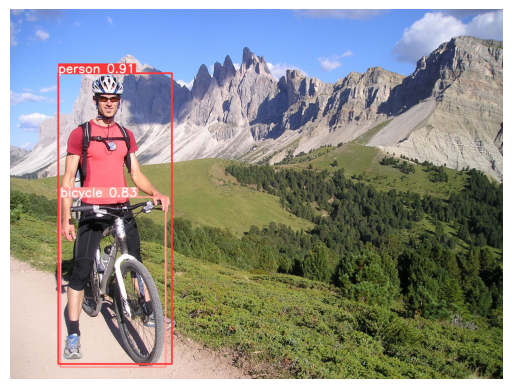


----------------------------------------------------------------------------------------------------
# OPEN IMAGE V7 YOLO #
----------------------------------------------------------------------------------------------------

image 1/1 C:\Development\BikeHelmetDetection\test\images\image5.jpg: 480x640 1 Bicycle, 1 Bicycle helmet, 1 Person, 157.0ms
Speed: 51.0ms preprocess, 157.0ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict5


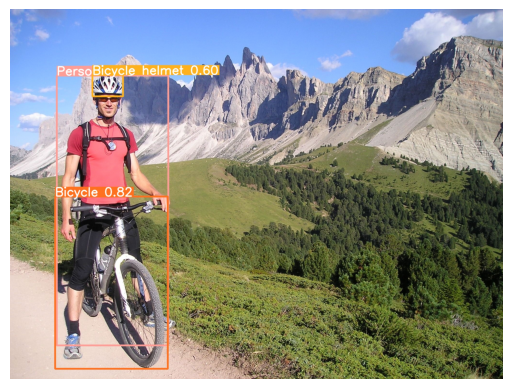


----------------------------------------------------------------------------------------------------
# FINE-TUNED YOLO / HELMET DATASET #
----------------------------------------------------------------------------------------------------

image 1/1 C:\Development\BikeHelmetDetection\test\images\image5.jpg: 480x640 1 with helmet, 112.0ms
Speed: 5.0ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict6


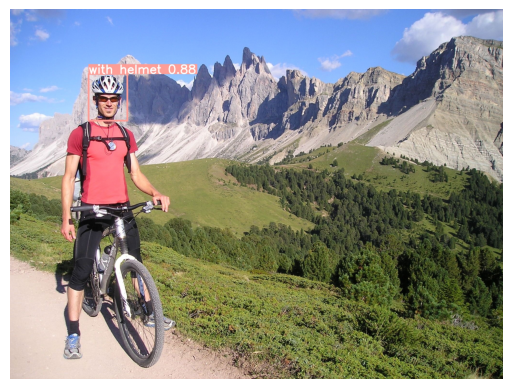

In [7]:
def get_test_image(img_dir=None):
    '''
    Get a random image from a directory, test/images by default

    Args:
        img_dir: str: path to the directory containing images

    '''

    # Load a random image
    if img_dir is None:
        img_dir = test_img_dir

    # pick a random image from the val set
    img_file = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
    print(img_file)

    return img_file

def predict_on_image(img_file, model=None, classes=None):
    '''
    Predict and display persons and bikes in an image using the YOLO model

    Args:
        img_file: str: path to the image file
        model: YOLO: YOLO model
        classes: list: filter classes to predict
    '''

    # Load model
    if model is None:
        model = YOLO('yolov8n.pt')  # YOLOv8n model

    os.makedirs(predict_dir, exist_ok=True)

    # Set the confidence threshold
    conf_thresh = 0.25

    # Predict all classes if filter classes are not provided
    if not classes:
        classes = list(model.names.keys())

    # predict on image
    results = model.predict(source=img_file, classes=classes, save=True, conf=conf_thresh)

    for result in results:

        # Save the image
        img_pred = os.path.join(project_dir, 'predict', os.path.split(img_file)[-1])
        result.save(img_pred)

        # Display the image
        image = Image.open(img_pred)
        plt.imshow(image)
        plt.axis('off')  # Turn off axis
        plt.show()


img_file = get_test_image()

print(f"\n{100*'-'}\n# COCO YOLO #\n{100*'-'}")
coco_classes = [0, 1]  # person, bicycle
predict_on_image(img_file, model=coco_yolo, classes=coco_classes)

print(f"\n{100*'-'}\n# OPEN IMAGE V7 YOLO #\n{100*'-'}")
oiv7_classes = [322, 594, 381, 42, 43]  # man, woman, person, bicycle, bicycle helmet
predict_on_image(img_file, model=oiv7_yolo, classes=oiv7_classes)

print(f"\n{100*'-'}\n# FINE-TUNED YOLO / HELMET DATASET #\n{100*'-'}")
predict_on_image(img_file, model=my_yolo)

# Testing the model on webcam

Grab your helmet and plug-in your webcam, let's try our prediction model on ourselves!  

In [39]:
# load latest model
model = YOLO(os.path.join(models_dir, 'best_260424_0028.pt'))

# Set webcam as source and set resolution
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

# set webcam fps
cap.set(cv2.CAP_PROP_FPS, 15)

# Load my model
model = YOLO(f'{models_dir}/best_260424_0028.pt')

while cap.isOpened():

    # load and flip current frame
    success, frame = cap.read()
    frame = cv2.flip(frame, 1)

    if success:
        # track on frame and plot result
        results = model.track(frame, verbose=False, conf=0.1)
        frame = results[0].plot()
        cv2.imshow("Webcam Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Helper method to parse and draw results

We define here a few methods to simplify parsing the results from the models and drawing the bounding boxes on images.

In [ ]:
def parse_results(results, model, classes=None):
    '''
    Parse the tracking or prediction results of a YOLO model and store them in a list of dicts
    Each dict contains the class, confidence and bounding box coordinates

    Args:
        results: YOLO results object
        model: YOLO: YOLO model used to predict the results
        classes: list: list of classes to filter the results (None by default)
    
    Return:
        results_list: list: list of dictionaries containing the class, confidence and bounding box coordinates
    '''

    if classes is None:
        classes = model.names
        
    results_list = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            pred = {}
            box_cls = int(box.cls[0])
            if box_cls not in classes:
                continue
            pred['class'] = model.names[box_cls]
            pred['confidence'] = round(float(box.conf[0]), 3)
            pred['bbox'] = tuple(map(int, box.xyxy[0]))
            results_list.append(pred)

    return results_list

def print_predictions(results_list):
    '''
    Print the tracking/prediction results from a YOLO model

    Args:
        results_list: list: list of dictionaries returned by parse_results
    '''

    for i, result in enumerate(results_list):
        print(f"Prediction {i+1}:")

        for k, v in result.items():
            print(f'{k}: {v}')

        print()

def draw_result_on_frame(frame, result, color, label=None, position='top-left'):
    '''
    Draw a track/prediction result label and bounding box on an image

    Args:
        frame: np.array: frame to draw the bounding box on
        result: dict: result dict containing class, confidence and bounding box coordinates
        color: tuple: BGR color of the bounding box
        label: str: label to display (None by default)
        position: str: position of the label (top-left, top-right, bottom-left, bottom-right)
    
    Return:
        frame: np.array: modified frame with the bounding box and label drawn on it
    '''
    
    x1, y1, x2, y2 = result['bbox']
    
    # draw bounding box
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

    # draw label
    if label and position in ['top-left', 'top-right', 'bottom-left', 'bottom-right']:
        if position == 'top-left':
            label_pos = x1, y1-5
        elif position == 'top-right':
            label_pos = x2, y1
        elif position == 'bottom-left':
            label_pos = x1, y2
        elif position == 'bottom-right':
            label_pos = x2, y2-5
        
        cv2.putText(frame, f"{label} {result['confidence']}", label_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return frame

def get_bbox_center(bbox):
    '''
    Get the center coordinates of a bounding box

    Args:
        bbox: tuple: bounding box coordinates (x1, y1, x2, y2)
    
    Return:
        _: tuple: center of the bounding box (x, y)
    '''

    x1, y1, x2, y2 = bbox
    x = int((x1 + x2) / 2)
    y = int((y1 + y2) / 2)
    return (x, y)

def bbox_inside_bbox(bbox1, bbox2):
    '''
    Check if a bounding box center is inside another bounding box

    Args:
        bbox1: tuple: bounding box coordinates (x1, y1, x2, y2)
        bbox2: tuple: bounding box coordinates (x1, y1, x2, y2)
    
    Return:
        inside: bool: True if the center of bbox2 is inside bbox1, False otherwise
    '''

    x1, y1, x2, y2 = bbox1
    x_center, y_center = get_bbox_center(bbox2)

    inside = x1 < x_center < x2 and y1 < y_center < y2
    return inside

def combine_bboxes(*args, padding=0):
    '''
    Combine multiple bounding boxes into a single one framing all of them

    Args:
        args: tuples: bounding box coordinates (x1, y1, x2, y2)
        padding: int: padding to add or substract to the combined bounding box (0 by default)
    
    Return:
        combined_bbox: tuple: combined bounding box coordinates (x1, y1, x2, y2)
    '''

    combined_bbox = ()
    video_w, video_h = 640, 360

    for bbox in args:
        if not combined_bbox:
            combined_bbox = bbox
        else:
            x1, y1, x2, y2 = bbox
            x1_min, y1_min, x2_max, y2_max = combined_bbox
            combined_bbox = (
                max(min(x1, x1_min) - padding, 0),
                max(min(y1, y1_min) - padding, 0),
                min(max(x2, x2_max) + padding, video_w),
                min(max(y2, y2_max) + padding, video_h)
            )

    return combined_bbox

def track_cyclist_with_helmet(frame, results_list, debug=False):
    '''
    Split classification results into 3 groups and detect if a person is riding a bike with a helmet
    - Group1: person, man, woman
    - Group2: bicycle
    - Group3: bicycle helmet, with helmet
    
    Args:
        frame: np.array: image
        results_list: list: result dictionaries parsed by the parse_results function
        debug: bool: True to draw all bboxes on the frame, False to only draw the combined one
    
        Return:
            frame: np.array: modified frame with the bounding boxes and labels drawn on it
    '''

    # Split the results into 3 groups: persons, bycicles, helmets
    person_results = [result for result in results_list if result['class'].lower() in  ['person', 'man', 'woman']]
    bike_results = [result for result in results_list if result['class'].lower() == 'bicycle']
    helmet_results = [result for result in results_list if result['class'].lower() in ['bicycle helmet', 'with helmet']]
    
    # remove person detections when the top of the bounding touches the frame (helmet disapearing, false negative)
    person_results = [person for person in person_results if person['bbox'][1] > 2]

    # exit function if no person detected
    if not person_results:
        return frame

    # Order the results by decreasing confidence, to check the most confident predictions first
    # in case of overlapping bounding boxes
    person_results = sorted(person_results, key=lambda x: x['confidence'], reverse=True)
    bike_results = sorted(bike_results, key=lambda x: x['confidence'], reverse=True)
    helmet_results = sorted(helmet_results, key=lambda x: x['confidence'], reverse=True)
    
    # Only take the first person with the max confidence (we can only show one smiley face per frame)
    person = person_results[0]

    # Check if the person's bounding box contains a bike and a helmet bbox
    # We consider that a bounding box is contained inside another if its center is inside the other bbox
    bike_found = False
    helmet_found = False

    if debug:
        frame = draw_result_on_frame(frame, person, color=(255, 255, 255), label='Person', position='bottom-right')

    # look for a bike bbox inside the person bbox
    for bike in bike_results:
        if bbox_inside_bbox(person['bbox'], bike['bbox']):
            bike_found = True
            bike_results.remove(bike)  # remove it to avoid checking it again in case of overlapping bboxes
            if debug:
                frame = draw_result_on_frame(frame, bike, color=(255, 255, 255), label='Bicycle', position='bottom-right')
            break
    
    # look for a helmet bbox inside the porson bbox
    for helmet in helmet_results:
        if bbox_inside_bbox(person['bbox'], helmet['bbox']):
            helmet_found = True
            helmet_results.remove(helmet)
            if debug:
                frame = draw_result_on_frame(frame, helmet, color=(255, 255, 255), label='Helmet', position='bottom-right')
            break
    
    # biker with helmet
    if bike_found and helmet_found:
        cyclist = {
            'class': 'Cyclist with Helmet', 
            'confidence': round(mean([person['confidence'], bike['confidence'], helmet['confidence']]), 3),
            'bbox': combine_bboxes(person['bbox'], bike['bbox'], helmet['bbox'], padding=3)
            }
        color = (0, 255, 0)  # green
        smiley = cv2.imread(os.path.join(medias_dir, 'smiley_green.png'))


    # biker without helmet
    elif bike_found and not helmet_found:
        color = (0, 0, 255)  # red
        cyclist = {
            'class': 'Cyclist without Helmet', 
            'confidence': round(mean([person['confidence'], bike['confidence']]), 3),
            'bbox': combine_bboxes(person['bbox'], bike['bbox'], padding=3)
            }
        smiley = cv2.imread(os.path.join(medias_dir, 'smiley_red.png'), cv2.IMREAD_UNCHANGED)
    
    # We found a pedestrian or another person object
    else:
        return frame
    
    # draw the cyclist bbox and label, greed if cyclist with helmet, red if cyclist without helmet
    frame = draw_result_on_frame(frame, cyclist, color=color, label=cyclist['class'], position='top-left')

    # draw a smiley face in the bottom right corner
    smiley_size = 100
    smiley = cv2.resize(smiley, (smiley_size, smiley_size))
    frame[-smiley_size:, -smiley_size:] = smiley
        
    return frame

def tracking_thread(frame, model, result_dict, classes, conf):
    '''
    Track objects on a frame using a given model and store the results in a given dictionary.
    We modify the results dictionary in place, as we cannot return it and get the results from the thread.

    Args:
        frame: np.array: video frame
        model: YOLO: YOLO model used to track the objects
        result_dict: dict: dictionary passed as reference to store the tracking results
        classes: list: list of classes to track
        conf: float: confidence threshold
    '''
    
    result_dict[model] = model.track(frame, verbose=False, persist=True, classes=classes, conf=conf)[0]

# Predict on a Video File

In [ ]:
def track_on_video(video_path, tracking_assignment, conf, output_path=None):
    '''
    Track objects on a video using one or multiple YOLO models and classes.
    Each tracking assignment is a tuple containing a YOLO model and a list of classes to track.
    The tracking is done on separate threads to speed up the process.

    Args:
        video_path: str: path to the video file
        tracking_assignment: list: list of tuples (model, [classes]) containing the YOLO model and
            the classes to track
        conf: float: confidence threshold
        output_path: str: path to save the tracked video (Skip saving if None)
    '''

    cap = cv2.VideoCapture(video_path)
    video_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_fps = cap.get(cv2.CAP_PROP_FPS)

    debug = False  # debug flag to draw all bboxes

    # FPS counter reinitialized every second
    fps_count = 0
    fps_value = 0
    fps_time_counter = datetime.now()

    if output_path:
        out = cv2.VideoWriter(output_path, -1, video_fps, (video_w, video_h))
    
    while cap.isOpened(): 

        # load current frame
        success, frame = cap.read()

        # restart video if no more frame
        if frame is None:
            break

        # Calculate FPS
        fps_count += 1
        if datetime.now() - fps_time_counter > timedelta(seconds=1):
            fps_value = fps_count
            fps_count = 0
            fps_time_counter = datetime.now()

        # Keyboard shortcuts
        key = cv2.waitKey(1) & 0xFF
        # toggle debug mode
        if key == ord('d'):
            debug = not debug
        # rewind video
        elif key == ord('r'):
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue
        # quit video
        elif key == ord('q'):
            break

        if success:

            # track each model on the frame on a separate thread
            results = {}
            track_threads = []

            # create and start threads
            for model, classes in tracking_assignment:
                thread = threading.Thread(target=tracking_thread, args=(frame, model, results, classes, conf))
                thread.start()
                track_threads.append(thread)

            # Wait for the threads to finish
            for thread in track_threads:
                thread.join()

            # combine results from all models
            result_list = []
            for model, result in results.items():
                result_list += parse_results(result, model)

            # send the combined results to the tracking function to display the bounding boxes
            frame = track_cyclist_with_helmet(frame, result_list, filter_best=True, debug=debug)
            
            # display FPS counter on a black background
            frame_h = frame.shape[0]
            cv2.rectangle(frame, (0, frame_h-20), (70, frame_h), (0, 0, 0), -1)
            cv2.putText(frame, f"FPS: {fps_value}", (0, frame_h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # display the final frame
            cv2.imshow('Video Detection', frame)

            # write to video file if output path is provided
            if output_path:
                out.write(frame)

    cap.release()
    if output_path:
        out.release()
    cv2.destroyAllWindows()


In [ ]:
# Main
video_file = 'video1.mp4'
video_path = os.path.join(test_videos_dir, video_file)

# Define the tracking assignment (which model should track which class)
tracking_assignment = [
    # (oiv7_yolo, [322, 594, 381, 42, 43]),  # person, man, woman and bike
    (coco_yolo, [0, 1]),  # person, bike
    (my_yolo, [1])  # helmet
]
# Predict on frame and save results to a video file
output_file = f"{video_file[:-4]}_tracked_{datetime.now().strftime('%d%m%y_%H%M%S')}.{video_file[-4:]}"
output_path = os.path.join(predict_dir, output_file)

track_on_video(video_path, tracking_assignment, conf=0.1, output_path=output_path)